# 최근접 이웃(K-Nearest Neighbor)

* 특별한 예측 모델 없이 가장 가까운 데이터 포인트를 기반으로 예측을 수행하는 방법
* 분류와 회귀 모두 지원

![k nearest neighbor](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/220px-KnnClassification.svg.png)

In [ ]:
import pandas as pd
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid'])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.manifold import TSNE
from sklearn.datasets import load_iris, load_breast_cancer, load_wine
from sklearn.datasets import load_boston, fetch_california_housing
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

## K 최근접 이웃 분류

* 입력 데이터 포인트와 가장 가까운 k개의 훈련 데이터 포인트가 출력
* k개의 데이터 포인트 중 가장 많은 클래스가 예측 결과

### 붓꽃 데이터

In [ ]:
iris = load_iris()

In [ ]:
iris_df = pd.DataFrame(data = iris.data, columns = iris.feature_names)
iris_df['Target'] = iris.target
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [ ]:
X,y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

In [ ]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [ ]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
print("학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test, y_test)))

학습 데이터 점수: 0.9583333333333334
평가 데이터 점수: 1.0


In [ ]:
model = KNeighborsClassifier()
model.fit(X_train_scale, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
print("학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test, y_test)))

학습 데이터 점수: 0.31666666666666665
평가 데이터 점수: 0.4


In [ ]:
cross_validate(
    estimator = KNeighborsClassifier(),
    X=X, y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.1s finished


{'fit_time': array([0.00157905, 0.00106549, 0.0008266 , 0.00068188, 0.0006969 ]),
 'score_time': array([0.00307631, 0.00199485, 0.00283957, 0.00268722, 0.00264955]),
 'test_score': array([0.96666667, 1.        , 0.93333333, 0.96666667, 1.        ])}

In [ ]:
param_grid = [{'n_neighbors':[3,5,7],
               'weights':['uniform','distance'],
               'algorithm':['ball_tree','kd_tree','brute']}]

In [ ]:
gs = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid = param_grid,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

In [ ]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  90 out of  90 | elapsed:    0.2s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=2,
             param_grid=[{'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                          'n_neighbors': [3, 5, 7],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=True)

In [ ]:
gs.best_estimator_

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [ ]:
print('GridSearchCV best score: {}'.format(gs.best_score_))

GridSearchCV best score: 0.9800000000000001


In [ ]:
def make_meshgrid(x, y, h=.02):
  x_min, x_max = x.min()-1, x.max()+1
  y_min, y_max = y.min()-1, y.max()+1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                       np.arange(y_min, y_max, h))
  return xx, yy

def plot_contours(clf, xx, yy, **params):
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  out = plt.contourf(xx, yy, Z, **params)

  return out

In [ ]:
tsne = TSNE(n_components=2)
X_comp = tsne.fit_transform(X)

In [ ]:
iris_comp_df = pd.DataFrame(data=X_comp)
iris_comp_df['Target'] = y
iris_comp_df

,0,1,Target
0,0.434661,-23.969675,0
1,-0.569465,-26.598564,0
2,0.618024,-26.440062,0
3,0.232593,-26.892242,0
4,0.863116,-23.988768,0
...,...,...,...
145,-2.364468,15.306196,2
146,-1.058485,12.344853,2
147,-2.049689,14.447271,2
148,-3.112952,15.866980,2


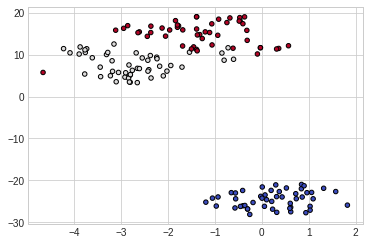

In [ ]:
plt.scatter(X_comp[:,0], X_comp[:,1],
            c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [ ]:
model = KNeighborsClassifier()
model.fit(X_comp, y)
predict = model.predict(X_comp)

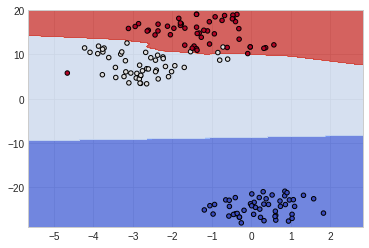

In [ ]:
xx,yy = make_meshgrid(X_comp[:, 0], X_comp[:,1])
plot_contours(model, xx, yy, cmap=plt.cm.coolwarm, alpha=.8)
plt.scatter(X_comp[:,0], X_comp[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

### 유방암 데이터

In [ ]:
cancer = load_breast_cancer()

In [ ]:
cancer_df = pd.DataFrame(data=cancer.data, columns=cancer.feature_names)
cancer_df['Target'] = cancer.target
cancer_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [ ]:
X, y = cancer.data, cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [ ]:
cancer_train_df = pd.DataFrame(data=X_train, columns=cancer.feature_names)
cancer_train_df['target'] = y_train
cancer_train_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.85,13.23,114.60,992.1,0.07838,0.06217,0.044450,0.041780,0.1220,0.05243,0.4834,1.0460,3.1630,50.950,0.004369,0.008274,0.011530,0.007437,0.01302,0.001309,19.820,18.42,127.10,1210.0,0.09862,0.09976,0.10480,0.08341,0.1783,0.05871,1
1,12.34,12.27,78.94,468.5,0.09003,0.06307,0.029580,0.026470,0.1689,0.05808,0.1166,0.4957,0.7714,8.955,0.003681,0.009169,0.008732,0.005740,0.01129,0.001366,13.610,19.27,87.22,564.9,0.12920,0.20740,0.17910,0.10700,0.3110,0.07592,1
2,12.88,18.22,84.45,493.1,0.12180,0.16610,0.048250,0.053030,0.1709,0.07253,0.4426,1.1690,3.1760,34.370,0.005273,0.023290,0.014050,0.012440,0.01816,0.003299,15.050,24.37,99.31,674.7,0.14560,0.29610,0.12460,0.10960,0.2582,0.08893,1
3,7.76,24.54,47.92,181.0,0.05263,0.04362,0.000000,0.000000,0.1587,0.05884,0.3857,1.4280,2.5480,19.150,0.007189,0.004660,0.000000,0.000000,0.02676,0.002783,9.456,30.37,59.16,268.6,0.08996,0.06444,0.00000,0.00000,0.2871,0.07039,1
4,11.22,33.81,70.79,386.8,0.07780,0.03574,0.004967,0.006434,0.1845,0.05828,0.2239,1.6470,1.4890,15.460,0.004359,0.006813,0.003223,0.003419,0.01916,0.002534,12.360,41.78,78.44,470.9,0.09994,0.06885,0.02318,0.03002,0.2911,0.07307,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,11.66,17.07,73.70,421.0,0.07561,0.03630,0.008306,0.011620,0.1671,0.05731,0.3534,0.6724,2.2250,26.030,0.006583,0.006991,0.005949,0.006296,0.02216,0.002668,13.280,19.74,83.61,542.5,0.09958,0.06476,0.03046,0.04262,0.2731,0.06825,1
451,19.79,25.12,130.40,1192.0,0.10150,0.15890,0.254500,0.114900,0.2202,0.06113,0.4953,1.1990,2.7650,63.330,0.005033,0.031790,0.047550,0.010430,0.01578,0.003224,22.630,33.58,148.70,1589.0,0.12750,0.38610,0.56730,0.17320,0.3305,0.08465,0
452,17.30,17.08,113.00,928.2,0.10080,0.10410,0.126600,0.083530,0.1813,0.05613,0.3093,0.8568,2.1930,33.630,0.004757,0.015030,0.023320,0.012620,0.01394,0.002362,19.850,25.09,130.90,1222.0,0.14160,0.24050,0.33780,0.18570,0.3138,0.08113,0
453,14.04,15.98,89.78,611.2,0.08458,0.05895,0.035340,0.029440,0.1714,0.05898,0.3892,1.0460,2.6440,32.740,0.007976,0.012950,0.016080,0.009046,0.02005,0.002830,15.660,21.58,101.20,750.0,0.11950,0.12520,0.11170,0.07453,0.2725,0.07234,1


In [ ]:
cancer_test_df = pd.DataFrame(data=X_test, columns=cancer.feature_names)
cancer_test_df['target'] = y_test
cancer_test_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,11.87,21.54,76.83,432.0,0.06613,0.10640,0.087770,0.023860,0.1349,0.06612,0.2560,1.5540,1.955,20.240,0.006854,0.060630,0.066630,0.015530,0.02354,0.008925,12.790,28.18,83.51,507.2,0.09457,0.33990,0.32180,0.08750,0.2305,0.09952,1
1,13.71,20.83,90.20,577.9,0.11890,0.16450,0.093660,0.059850,0.2196,0.07451,0.5835,1.3770,3.856,50.960,0.008805,0.030290,0.024880,0.014480,0.01486,0.005412,17.060,28.14,110.60,897.0,0.16540,0.36820,0.26780,0.15560,0.3196,0.11510,0
2,12.63,20.76,82.15,480.4,0.09933,0.12090,0.106500,0.060210,0.1735,0.07070,0.3424,1.8030,2.711,20.480,0.012910,0.040420,0.051010,0.022950,0.02144,0.005891,13.330,25.47,89.00,527.4,0.12870,0.22500,0.22160,0.11050,0.2226,0.08486,1
3,19.80,21.56,129.70,1230.0,0.09383,0.13060,0.127200,0.086910,0.2094,0.05581,0.9553,1.1860,6.487,124.400,0.006804,0.031690,0.034460,0.017120,0.01897,0.004045,25.730,28.64,170.30,2009.0,0.13530,0.32350,0.36170,0.18200,0.3070,0.08255,0
4,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.197400,0.127900,0.2069,0.05999,0.7456,0.7869,4.585,94.030,0.006150,0.040060,0.038320,0.020580,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.45040,0.24300,0.3613,0.08758,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,14.78,23.94,97.40,668.3,0.11720,0.14790,0.126700,0.090290,0.1953,0.06654,0.3577,1.2810,2.450,35.240,0.006703,0.023100,0.023150,0.011840,0.01900,0.003224,17.310,33.39,114.60,925.1,0.16480,0.34160,0.30240,0.16140,0.3321,0.08911,0
110,9.00,14.40,56.36,246.3,0.07005,0.03116,0.003681,0.003472,0.1788,0.06833,0.1746,1.3050,1.144,9.789,0.007389,0.004883,0.003681,0.003472,0.02701,0.002153,9.699,20.07,60.90,285.5,0.09861,0.05232,0.01472,0.01389,0.2991,0.07804,1
111,14.60,23.29,93.97,664.7,0.08682,0.06636,0.083900,0.052710,0.1627,0.05416,0.4157,1.6270,2.914,33.010,0.008312,0.017420,0.033890,0.015760,0.01740,0.002871,15.790,31.71,102.20,758.2,0.13120,0.15810,0.26750,0.13590,0.2477,0.06836,0
112,13.27,14.76,84.74,551.7,0.07355,0.05055,0.032610,0.026480,0.1386,0.05318,0.4057,1.1530,2.701,36.350,0.004481,0.010380,0.013580,0.010820,0.01069,0.001435,16.360,22.35,104.50,830.6,0.10060,0.12380,0.13500,0.10010,0.2027,0.06206,1


In [ ]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [ ]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
print("학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test, y_test)))

학습 데이터 점수: 0.9516483516483516
평가 데이터 점수: 0.8771929824561403


In [ ]:
model = KNeighborsClassifier()
model.fit(X_train_scale, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
print("학습 데이터 점수: {}".format(model.score(X_train_scale, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test_scale, y_test)))

학습 데이터 점수: 0.978021978021978
평가 데이터 점수: 0.9736842105263158


In [ ]:
estimator = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)

In [ ]:
cross_validate(
    estimator = estimator,
    X=X, y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.1s finished


{'fit_time': array([0.00303578, 0.00371695, 0.00330472, 0.00329161, 0.00309062]),
 'score_time': array([0.01067615, 0.01369977, 0.0116961 , 0.01167321, 0.00878263]),
 'test_score': array([0.96491228, 0.95614035, 0.98245614, 0.95614035, 0.96460177])}

In [ ]:
pipe = Pipeline(
    [('scaler', StandardScaler()),
     ('model', KNeighborsClassifier())]
)

In [ ]:
param_grid = [{'model__n_neighbors':[3,5,7],
               'model__weights':['uniform', 'distance'],
               'model__algorithm':['ball_tree','kd_tree', 'brute']}]

In [ ]:
gs = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

In [ ]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  90 out of  90 | elapsed:    0.6s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
      

In [ ]:
gs.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=7, p=2,
                                      weights='uniform'))],
         verbose=False)

In [ ]:
print('GridSearchCV best score: {}'.format(gs.best_score_))

GridSearchCV best score: 0.9701288619779538


In [ ]:
tsne = TSNE(n_components=2)
X_comp = tsne.fit_transform(X)

In [ ]:
cancer_comp_df = pd.DataFrame(data=X_comp)
cancer_comp_df['target'] = y
cancer_comp_df

,0,1,target
0,34.897865,2.799671,0
1,32.220078,3.693378,0
2,28.880665,0.071683,0
3,-23.204407,9.439353,0
4,29.384737,-2.264644,0
...,...,...,...
564,32.359123,5.445168,0
565,30.012619,0.282125,0
566,15.155284,-12.429306,0
567,30.787785,1.997665,0


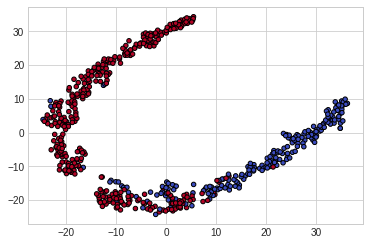

In [ ]:
plt.scatter(X_comp[:,0], X_comp[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [ ]:
model = KNeighborsClassifier()
model.fit(X_comp, y)
predict = model.predict(X_comp)

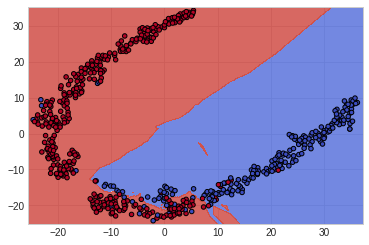

In [ ]:
xx, yy = make_meshgrid(X_comp[:,0], X_comp[:,1])
plot_contours(model, xx, yy, cmap = plt.cm.coolwarm, alpha=.8)
plt.scatter(X_comp[:,0], X_comp[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

## 와인 데이터

In [ ]:
wine = load_wine()

In [ ]:
wine_df = pd.DataFrame(data=wine.data, columns=wine.feature_names)
wine_df['Target'] = wine.target
wine_df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


In [ ]:
X, y = wine.data, wine.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [ ]:
wine_train_df = pd.DataFrame(data=X_train, columns=wine.feature_names)
wine_train_df['target'] = y_train
wine_train_df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.38,3.59,2.28,16.0,102.0,3.25,3.17,0.27,2.19,4.90,1.04,3.44,1065.0,0
1,12.04,4.30,2.38,22.0,80.0,2.10,1.75,0.42,1.35,2.60,0.79,2.57,580.0,1
2,11.62,1.99,2.28,18.0,98.0,3.02,2.26,0.17,1.35,3.25,1.16,2.96,345.0,1
3,13.17,5.19,2.32,22.0,93.0,1.74,0.63,0.61,1.55,7.90,0.60,1.48,725.0,2
4,13.67,1.25,1.92,18.0,94.0,2.10,1.79,0.32,0.73,3.80,1.23,2.46,630.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,13.62,4.95,2.35,20.0,92.0,2.00,0.80,0.47,1.02,4.40,0.91,2.05,550.0,2
138,12.22,1.29,1.94,19.0,92.0,2.36,2.04,0.39,2.08,2.70,0.86,3.02,312.0,1
139,12.08,1.39,2.50,22.5,84.0,2.56,2.29,0.43,1.04,2.90,0.93,3.19,385.0,1
140,12.00,3.43,2.00,19.0,87.0,2.00,1.64,0.37,1.87,1.28,0.93,3.05,564.0,1


In [ ]:
wine_test_df = pd.DataFrame(data=X_test, columns=wine.feature_names)
wine_test_df['target'] = y_test
wine_test_df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,12.37,1.21,2.56,18.1,98.0,2.42,2.65,0.37,2.08,4.60,1.19,2.30,678.0,1
1,13.05,3.86,2.32,22.5,85.0,1.65,1.59,0.61,1.62,4.80,0.84,2.01,515.0,1
2,12.85,3.27,2.58,22.0,106.0,1.65,0.60,0.60,0.96,5.58,0.87,2.11,570.0,2
3,12.96,3.45,2.35,18.5,106.0,1.39,0.70,0.40,0.94,5.28,0.68,1.75,675.0,2
4,12.08,1.13,2.51,24.0,78.0,2.00,1.58,0.40,1.40,2.20,1.31,2.72,630.0,1
5,13.82,1.75,2.42,14.0,111.0,3.88,3.74,0.32,1.87,7.05,1.01,3.26,1190.0,0
6,12.37,0.94,1.36,10.6,88.0,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520.0,1
7,12.64,1.36,2.02,16.8,100.0,2.02,1.41,0.53,0.62,5.75,0.98,1.59,450.0,1
8,13.05,1.65,2.55,18.0,98.0,2.45,2.43,0.29,1.44,4.25,1.12,2.51,1105.0,0
9,11.46,3.74,1.82,19.5,107.0,3.18,2.58,0.24,3.58,2.90,0.75,2.81,562.0,1


In [ ]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [ ]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
print("학습 데이터 점수: {}".format(model.score(X_train, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test, y_test)))

학습 데이터 점수: 0.8098591549295775
평가 데이터 점수: 0.6388888888888888


In [ ]:
model = KNeighborsClassifier()
model.fit(X_train_scale, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
print("학습 데이터 점수: {}".format(model.score(X_train_scale, y_train)))
print("평가 데이터 점수: {}".format(model.score(X_test_scale, y_test)))

학습 데이터 점수: 0.9859154929577465
평가 데이터 점수: 0.9444444444444444


In [ ]:
estimator = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)

In [ ]:
cross_validate(
    estimator = estimator,
    X=X, y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.0s finished


{'fit_time': array([0.002877  , 0.00275278, 0.00216174, 0.00168824, 0.00166917]),
 'score_time': array([0.0038352 , 0.00366306, 0.00472569, 0.00295615, 0.00288653]),
 'test_score': array([0.94444444, 0.94444444, 0.97222222, 1.        , 0.88571429])}

In [ ]:
pipe = Pipeline(
    [('scaler', StandardScaler()),
     ('model', KNeighborsClassifier())]
)

In [ ]:
param_grid = [{'model__n_neighbors':[3,5,7],
               'model__weights':['uniform', 'distance'],
               'model__algorithm':['ball_tree','kd_tree', 'brute']}]

In [ ]:
gs = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

In [ ]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  90 out of  90 | elapsed:    0.3s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
      

In [ ]:
gs.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=7, p=2,
                                      weights='uniform'))],
         verbose=False)

In [ ]:
print('GridSearchCV best score: {}'.format(gs.best_score_))

GridSearchCV best score: 0.9665079365079364


In [ ]:
tsne = TSNE(n_components=2)
X_comp = tsne.fit_transform(X)

In [ ]:
wine_comp_df = pd.DataFrame(data=X_comp)
wine_comp_df['target'] = y
wine_comp_df

,0,1,target
0,-3.853275,11.234120,0
1,-3.983930,10.840194,0
2,-4.821891,13.266350,0
3,-5.703550,15.988208,0
4,-1.695968,2.778176,0
...,...,...,...
173,-2.089675,2.645603,2
174,-2.170063,3.077366,2
175,-2.828525,5.622087,2
176,-2.949630,5.763271,2


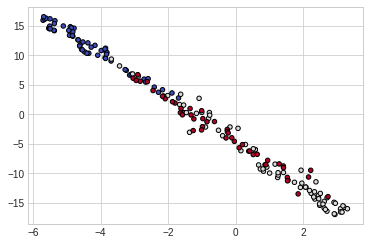

In [ ]:
plt.scatter(X_comp[:,0], X_comp[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [ ]:
model = KNeighborsClassifier()
model.fit(X_comp, y)
predict = model.predict(X_comp)

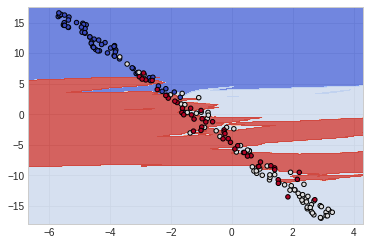

In [ ]:
xx, yy = make_meshgrid(X_comp[:,0], X_comp[:,1])
plot_contours(model, xx, yy, cmap = plt.cm.coolwarm, alpha=.8)
plt.scatter(X_comp[:,0], X_comp[:,1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k');

## k 최근접 이웃 회귀

* k 최근접 이웃 분류와 마찬가지로 예측에 이웃 데이터 포인트 사용
* 이웃 데이터 포인트의 평균이 예측 결과

### 보스턴 주택 가격 데이터

In [ ]:
boston = load_boston()

In [ ]:
boston_df = pd.DataFrame(data=boston.data, columns=boston.feature_names)
boston_df['target'] = boston.target
boston_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [ ]:
X, y = boston.data, boston.target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

In [ ]:
boston_train_df = pd.DataFrame(data=X_train, columns = boston.feature_names)
boston_train_df['target']=  y_train
boston_train_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.22876,0.0,8.56,0.0,0.520,6.405,85.4,2.7147,5.0,384.0,20.9,70.80,10.63,18.6
1,0.21409,22.0,5.86,0.0,0.431,6.438,8.9,7.3967,7.0,330.0,19.1,377.07,3.59,24.8
2,0.22969,0.0,10.59,0.0,0.489,6.326,52.5,4.3549,4.0,277.0,18.6,394.87,10.97,24.4
3,0.03738,0.0,5.19,0.0,0.515,6.310,38.5,6.4584,5.0,224.0,20.2,389.40,6.75,20.7
4,0.75026,0.0,8.14,0.0,0.538,5.924,94.1,4.3996,4.0,307.0,21.0,394.33,16.30,15.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,0.11329,30.0,4.93,0.0,0.428,6.897,54.3,6.3361,6.0,300.0,16.6,391.25,11.38,22.0
400,0.02498,0.0,1.89,0.0,0.518,6.540,59.7,6.2669,1.0,422.0,15.9,389.96,8.65,16.5
401,6.28807,0.0,18.10,0.0,0.740,6.341,96.4,2.0720,24.0,666.0,20.2,318.01,17.79,14.9
402,9.39063,0.0,18.10,0.0,0.740,5.627,93.9,1.8172,24.0,666.0,20.2,396.90,22.88,12.8


In [ ]:
boston_test_df = pd.DataFrame(data=X_test, columns = boston.feature_names)
boston_test_df['target']=  y_test
boston_test_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.78420,0.0,8.14,0.0,0.538,5.990,81.7,4.2579,4.0,307.0,21.0,386.75,14.67,17.5
1,2.30040,0.0,19.58,0.0,0.605,6.319,96.1,2.1000,5.0,403.0,14.7,297.09,11.10,23.8
2,13.07510,0.0,18.10,0.0,0.580,5.713,56.7,2.8237,24.0,666.0,20.2,396.90,14.76,20.1
3,0.08308,0.0,2.46,0.0,0.488,5.604,89.8,2.9879,3.0,193.0,17.8,391.00,13.98,26.4
4,4.81213,0.0,18.10,0.0,0.713,6.701,90.0,2.5975,24.0,666.0,20.2,255.23,16.42,16.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,0.03551,25.0,4.86,0.0,0.426,6.167,46.7,5.4007,4.0,281.0,19.0,390.64,7.51,22.9
98,12.24720,0.0,18.10,0.0,0.584,5.837,59.7,1.9976,24.0,666.0,20.2,24.65,15.69,10.2
99,0.61470,0.0,6.20,0.0,0.507,6.618,80.8,3.2721,8.0,307.0,17.4,396.90,7.60,30.1
100,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72,15.2


In [ ]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [ ]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [ ]:
print('학습 데이터 점수: {}'.format(model.score(X_train, y_train)))
print('평가 데이터 점수: {}'.format(model.score(X_test, y_test)))

학습 데이터 점수: 0.7010128365436208
평가 데이터 점수: 0.5696750090963764


In [ ]:
model = KNeighborsRegressor()
model.fit(X_train_scale, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [ ]:
print('학습 데이터 점수: {}'.format(model.score(X_train_scale, y_train)))
print('평가 데이터 점수: {}'.format(model.score(X_test_scale, y_test)))

학습 데이터 점수: 0.8302449518618386
평가 데이터 점수: 0.7673440478454878


In [ ]:
estimator = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor()
)

In [ ]:
cross_validate(
    estimator = estimator,
    X=X, y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    1.0s finished


{'fit_time': array([0.00355697, 0.00303698, 0.00248504, 0.00216484, 0.00198293]),
 'score_time': array([0.00350451, 0.00357985, 0.00287008, 0.00297308, 0.00219178]),
 'test_score': array([0.56089547, 0.61917359, 0.48661916, 0.46986886, 0.23133037])}

In [ ]:
pipe = Pipeline(
    [('scaler', StandardScaler()),
     ('model', KNeighborsRegressor())]
)

In [ ]:
param_grid = [{'model__n_neighbors':[3,5,7],
               'model__weights':['uniform', 'distance'],
               'model__algorithm':['ball_tree','kd_tree', 'brute']}]

In [ ]:
gs = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

In [ ]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  90 out of  90 | elapsed:    0.4s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        KNeighborsRegressor(algorithm='auto',
                                                            leaf_size=30,
                                                            metric='minkowski',
                                                            metric_params=None,
                                                            n_jobs=None,
                                                            n_neighbors=5, p=2,
                                                            weights='uniform'))],
                                verbose=False),
             

In [ ]:
gs.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 KNeighborsRegressor(algorithm='ball_tree', leaf_size=30,
                                     metric='minkowski', metric_params=None,
                                     n_jobs=None, n_neighbors=7, p=2,
                                     weights='distance'))],
         verbose=False)

In [ ]:
print('GridSearchCV best score: {}'.format(gs.best_score_))

GridSearchCV best score: 0.4973060611762845


In [ ]:
tsne = TSNE(n_components=1)
X_comp = tsne.fit_transform(X)

In [ ]:
boston_comp_df = pd.DataFrame(data=X_comp)
boston_comp_df['target'] = y
boston_comp_df

,0,target
0,16.571648,24.0
1,42.694626,21.6
2,38.999378,34.7
3,39.909477,33.4
4,40.170902,36.2
...,...,...
501,25.101505,22.4
502,25.743166,20.6
503,26.532040,23.9
504,26.487133,22.0


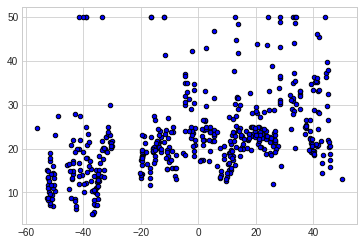

In [ ]:
plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [ ]:
model = KNeighborsRegressor()
model.fit(X_comp, y)
predict = model.predict(X_comp)

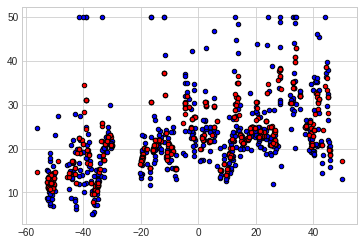

In [ ]:
plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k');
plt.scatter(X_comp, predict, c='r', cmap=plt.cm.coolwarm, s=20, edgecolors='k');

### 캘리포니아 주택 가격 데이터

In [ ]:
california = fetch_california_housing()

In [ ]:
california_df = pd.DataFrame(data=california.data, columns=california.feature_names)
california_df['target'] = california.target
california_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [ ]:
X, y = california.data, california.target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

In [ ]:
california_train_df = pd.DataFrame(data=X_train, columns = california.feature_names)
california_train_df['target']=  y_train
california_train_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,2.6302,33.0,6.071429,1.107143,717.0,3.658163,35.27,-118.83,0.81300
1,2.4201,46.0,4.891381,1.056671,2240.0,2.644628,38.10,-122.23,0.92800
2,2.8906,35.0,5.403141,1.083770,954.0,4.994764,34.08,-117.99,1.34800
3,2.0785,36.0,4.520000,1.046667,1469.0,4.896667,33.92,-118.19,1.39800
4,8.5403,23.0,7.851528,0.984716,1292.0,2.820961,33.77,-117.79,4.51300
...,...,...,...,...,...,...,...,...,...
16507,4.2788,23.0,5.767352,0.969152,2609.0,3.353470,33.90,-117.44,1.48700
16508,8.5407,22.0,7.366848,0.956522,1305.0,3.546196,33.81,-118.07,3.98800
16509,10.7309,52.0,7.850365,1.021898,762.0,2.781022,37.73,-122.47,5.00001
16510,2.5399,26.0,4.253593,1.038884,3086.0,2.608622,33.81,-116.50,0.94800


In [ ]:
california_test_df = pd.DataFrame(data=X_test, columns = california.feature_names)
california_test_df['target']=  y_test
california_test_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,2.1714,46.0,3.235135,1.124324,898.0,2.427027,37.34,-121.89,1.906
1,2.5868,16.0,5.617414,1.108179,932.0,2.459103,34.11,-117.64,1.469
2,6.4385,24.0,5.693727,0.948339,824.0,3.040590,34.04,-118.09,2.726
3,3.0119,30.0,4.048387,1.034274,1052.0,2.120968,34.18,-118.41,2.622
4,2.2552,14.0,2.429293,1.169192,2226.0,2.810606,34.07,-118.28,2.659
...,...,...,...,...,...,...,...,...,...
4123,6.9737,31.0,7.041436,0.980663,1044.0,2.883978,33.77,-117.88,2.888
4124,1.9176,24.0,4.234694,0.969388,279.0,1.423469,33.02,-117.06,1.211
4125,6.0648,36.0,5.898374,0.910569,608.0,2.471545,33.97,-118.01,2.908
4126,5.4663,25.0,7.498807,1.064439,1286.0,3.069212,33.12,-117.03,2.483


In [ ]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

In [ ]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [ ]:
print('학습 데이터 점수: {}'.format(model.score(X_train, y_train)))
print('평가 데이터 점수: {}'.format(model.score(X_test, y_test)))

학습 데이터 점수: 0.45173260089350104
평가 데이터 점수: 0.1501631056064956


In [ ]:
model = KNeighborsRegressor()
model.fit(X_train_scale, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [ ]:
print('학습 데이터 점수: {}'.format(model.score(X_train_scale, y_train)))
print('평가 데이터 점수: {}'.format(model.score(X_test_scale, y_test)))

학습 데이터 점수: 0.7929410688229391
평가 데이터 점수: 0.6808820340552153


In [ ]:
estimator = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor()
)

In [ ]:
cross_validate(
    estimator = estimator,
    X=X, y=y,
    cv=5,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    2.4s finished


{'fit_time': array([0.04073954, 0.0428443 , 0.03829455, 0.03789735, 0.03753805]),
 'score_time': array([0.58163357, 0.48629618, 0.51911736, 0.59120488, 0.3754065 ]),
 'test_score': array([0.47879396, 0.4760079 , 0.57624554, 0.50259828, 0.57228584])}

In [ ]:
pipe = Pipeline(
    [('scaler', StandardScaler()),
     ('model', KNeighborsRegressor())]
)

In [ ]:
param_grid = [{'model__n_neighbors':[3,5,7],
               'model__weights':['uniform', 'distance'],
               'model__algorithm':['ball_tree','kd_tree', 'brute']}]

In [ ]:
gs = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    n_jobs=multiprocessing.cpu_count(),
    verbose=True
)

In [ ]:
gs.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   22.9s
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=2)]: Done  90 out of  90 | elapsed:   58.7s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        KNeighborsRegressor(algorithm='auto',
                                                            leaf_size=30,
                                                            metric='minkowski',
                                                            metric_params=None,
                                                            n_jobs=None,
                                                            n_neighbors=5, p=2,
                                                            weights='uniform'))],
                                verbose=False),
             

In [ ]:
gs.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 KNeighborsRegressor(algorithm='ball_tree', leaf_size=30,
                                     metric='minkowski', metric_params=None,
                                     n_jobs=None, n_neighbors=7, p=2,
                                     weights='distance'))],
         verbose=False)

In [ ]:
print('GridSearchCV best score: {}'.format(gs.best_score_))

GridSearchCV best score: 0.5376515274379832


In [ ]:
tsne = TSNE(n_components=1)
X_comp = tsne.fit_transform(X)

In [ ]:
california_comp_df = pd.DataFrame(data=X_comp)
california_comp_df['target'] = y
california_comp_df

,0,target
0,52.204391,4.526
1,-16.238955,3.585
2,-8.626079,3.521
3,-22.902182,3.413
4,-23.386789,3.422
...,...,...
20635,4.024651,0.781
20636,39.773445,0.771
20637,90.039040,0.923
20638,-27.768196,0.847


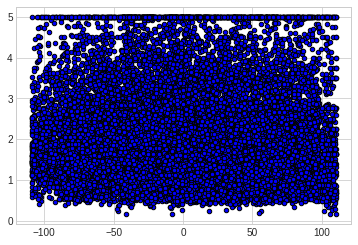

In [ ]:
plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k');

In [ ]:
model = KNeighborsRegressor()
model.fit(X_comp, y)
predict = model.predict(X_comp)

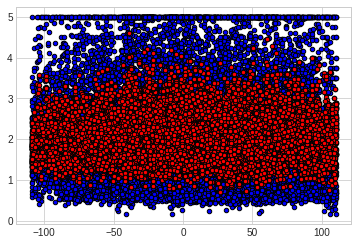

In [ ]:
plt.scatter(X_comp, y, c='b', cmap=plt.cm.coolwarm, s=20, edgecolors='k');
plt.scatter(X_comp, predict, c='r', cmap=plt.cm.coolwarm, s=20, edgecolors='k');